# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Finished Loading Data")

Finished Loading Data


---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:

import numpy as np

n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

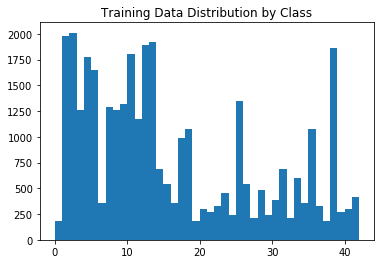

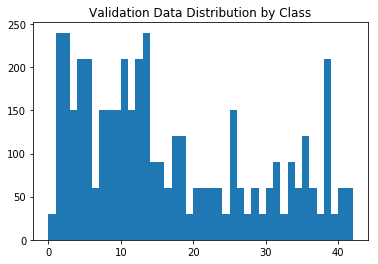

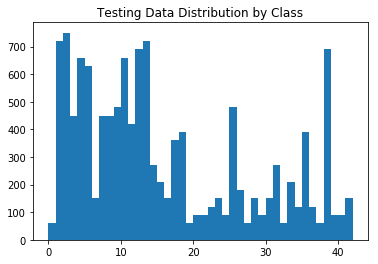

10


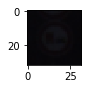

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

import random

# Distributions
binwidth = 1
plt.hist(y_train, bins=np.arange(min(y_train), max(y_train) + binwidth, binwidth))
plt.title("Training Data Distribution by Class")
plt.show()
plt.hist(y_valid, bins=np.arange(min(y_valid), max(y_valid) + binwidth, binwidth))
plt.title("Validation Data Distribution by Class")
plt.show()
plt.hist(y_test, bins=np.arange(min(y_test), max(y_test) + binwidth, binwidth))
plt.title("Testing Data Distribution by Class")
plt.show()

# Example image

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])




----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

3
Original Dataset : 34799
Largest class has 2010 elements
Filling class 0 with 1830 elements
Class 0 has now 2010 elements
Filling class 1 with 30 elements
Class 1 has now 2010 elements
Filling class 2 with 0 elements
Class 2 has now 2010 elements
Filling class 3 with 750 elements
Class 3 has now 2010 elements
Filling class 4 with 240 elements
Class 4 has now 2010 elements
Filling class 5 with 360 elements
Class 5 has now 2010 elements
Filling class 6 with 1650 elements
Class 6 has now 2010 elements
Filling class 7 with 720 elements
Class 7 has now 2010 elements
Filling class 8 with 750 elements
Class 8 has now 2010 elements
Filling class 9 with 690 elements
Class 9 has now 2010 elements
Filling class 10 with 210 elements
Class 10 has now 2010 elements
Filling class 11 with 840 elements
Class 11 has now 2010 elements
Filling class 12 with 120 elements
Class 12 has now 2010 elements
Filling class 13 with 90 elements
Class 13 has now 2010 elements
Filling class 14 with 1320 elements
Cla

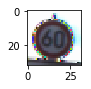

In [4]:
# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


# Normalize Data
X_train = (X_train - 128.0)/128.0
X_valid = (X_valid - 128.0)/128.0
X_test = (X_test - 128.0)/128.0

# Example image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

# Balance Data
import gc
def balance_data(train_x, train_y):
    """Makes ALL classes have the same distribution"""

    print('Original Dataset : {}'.format(train_x.shape[0]))

    max_count_index = np.bincount(train_y).argmax()
    max_count = np.where(train_y == max_count_index)[0].shape[0]
    
    print("Largest class has {} elements".format(max_count))

    xx = np.copy(train_x)
    yy = np.copy(train_y)

    #Over-Sampling
    for j in range(n_classes):
        mask_n = np.where(train_y == j)[0]
        num_to_oversample = max_count -  np.where(train_y == j)[0].shape[0]
        print("Filling class {} with {} elements".format(j,num_to_oversample))
        x_n = train_x[mask_n]
        y_n = train_y[mask_n]
        b_mask = np.random.RandomState().choice(x_n.shape[0], num_to_oversample)
        x_k = x_n[[b_mask]]
        y_k = y_n[[b_mask]]
        xx = np.concatenate((xx,x_k),axis=0)
        yy = np.concatenate((yy,y_k),axis=0)
        del x_n, y_n, x_k, y_k, mask_n, b_mask
        gc.collect()
        print("Class {} has now {} elements".format(j,np.where(yy == j)[0].shape[0]))

    print('Augmented Dataset : {}'.format(xx.shape[0]))
    
    return xx, yy

X_train, y_train = balance_data(X_train, y_train)


print("Finished Preprocessing Data")


### Model Architecture

In [ ]:
import tensorflow as tf

EPOCHS = 16
BATCH_SIZE = 64

def LeNet(x):    
    conv1_W = tf.get_variable("conv1_W", shape = [5, 5, 3, 6], initializer = tf.contrib.layers.xavier_initializer())
    conv1_b = tf.get_variable("conv1_b", shape = [6], initializer = tf.contrib.layers.xavier_initializer())
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.get_variable("conv2_W", shape = [5, 5, 6, 16], initializer = tf.contrib.layers.xavier_initializer())
    conv2_b = tf.get_variable("conv2_b", shape = [16], initializer = tf.contrib.layers.xavier_initializer())
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   =  tf.contrib.layers.flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.get_variable("fc1_W", shape = [400, 120], initializer = tf.contrib.layers.xavier_initializer())
    fc1_b = tf.get_variable("fc1_b", shape = [120], initializer = tf.contrib.layers.xavier_initializer())
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.get_variable("fc2_W", shape = [120, 84], initializer = tf.contrib.layers.xavier_initializer())
    fc2_b = tf.get_variable("fc2_b", shape = [84], initializer = tf.contrib.layers.xavier_initializer())
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W = tf.get_variable("fc3_W", shape = [84, n_classes], initializer = tf.contrib.layers.xavier_initializer())
    fc3_b = tf.get_variable("fc3_b", shape = [n_classes], initializer = tf.contrib.layers.xavier_initializer())
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

def dnn(x):
    
    y = LeNet(x)
    
    return y

print("Finished Defining DNN")

Finished Defining DNN


### Train, Validate and Test the Model

In [ ]:
# Helper Definitions

print(tf.__version__)

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = dnn(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

print("Finished Loading Graph")

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train & Validate

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        saver.save(sess, 'model')
        
    saver.save(sess, 'model')
    print("Model saved")
    
    print("Testing...")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    sess.close()


0.12.1
Finished Loading Graph
Training...

EPOCH 1 ...
Validation Accuracy = 0.893

EPOCH 2 ...
Validation Accuracy = 0.868

EPOCH 3 ...
Validation Accuracy = 0.919

EPOCH 4 ...
Validation Accuracy = 0.916

EPOCH 5 ...
Validation Accuracy = 0.941

EPOCH 6 ...
Validation Accuracy = 0.937

EPOCH 7 ...
Validation Accuracy = 0.949

EPOCH 8 ...
Validation Accuracy = 0.936

EPOCH 9 ...
Validation Accuracy = 0.951

EPOCH 10 ...
Validation Accuracy = 0.944

EPOCH 11 ...
Validation Accuracy = 0.941

EPOCH 12 ...
Validation Accuracy = 0.932

EPOCH 13 ...
Validation Accuracy = 0.936

EPOCH 14 ...
Validation Accuracy = 0.932

EPOCH 15 ...
Validation Accuracy = 0.942



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
import matplotlib.image as mpimg
from scipy.misc import imresize
from random import randint
import pandas as pd

n_images = 5

X_data = np.random.rand(n_images, 32,32,3)

y_data = np.random.rand(n_images)

info = pd.read_csv("test.csv", sep=';',header=0, names=['Filename', 'Width', 'Height','Roi.X1','Roi.Y1','Roi.X2','Roi.Y2','ClassId'])
mappings = pd.read_csv("signnames.csv", sep=',',header=0, names=['ClassId', 'SignName'])

for  i in range(n_images):
    file_name = "{:05d}.ppm".format(randint(0,12000))
    # X
    xx =  mpimg.imread("images/{}".format(file_name))
    xx = imresize(xx, (32, 32))
    X_data[i] = xx
    # Y
    yy = info.loc[info['Filename'] == file_name].iloc[0]['ClassId']
    y_data[i] = yy
    # Visualize
    sign_name = mappings.loc[mappings['ClassId'] == yy].iloc[0]['SignName']
    plt.figure(figsize=(1,1))
    plt.title(sign_name)
    plt.imshow(xx)
    
X_data = (X_data - 128.0)/128.0

print("Finished loading images")

### Predict the Sign Type for Each Image

In [ ]:
prob_vec = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess,'./model')
    for  i in range(X_data.shape[0]):
        probs = sess.run(prob_vec, feed_dict={x: np.expand_dims(X_data[i],axis=0)})
        prediction = np.argmax(probs)
        sign_name = mappings.loc[mappings['ClassId'] == prediction].iloc[0]['SignName']
        print("Sign number {} is predicted to be a {}".format(i,sign_name))
    sess.close()

### Analyze Performance

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,'./model')
    accuracy = evaluate(X_data, y_data)
    sess.close()
print("Accuracy = {:.3f}".format(accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
top_k = 5
with tf.Session() as sess:
    saver.restore(sess,'./model')
    all_values, all_indices = sess.run(tf.nn.top_k(prob_vec, k=top_k), feed_dict={x: X_data})
    i = 0
    sess.close()

for values, indices in zip(all_values,all_indices):
    n = 0
    print("\n")
    print("Sign #{}".format(i))
    plt.figure(figsize=(1,1))
    plt.imshow(X_data[i]*128.0+128.0)
    plt.show()
    sign_names = []
    for index in indices:
        sign_name = mappings.loc[mappings['ClassId'] == index].iloc[0]['SignName']
        sign_names.append(sign_name)
        print("{} % probability for Sign #{} is to be a {}".format(values[n]*100,i,sign_name))
        n += 1
    plt.barh(np.arange(len(sign_names)), values, align='center', alpha=0.5)
    plt.yticks(np.arange(len(sign_names)),sign_names)
    plt.xlabel('Probabilities')
    plt.title('Sign #{}'.format(i))
    plt.show()
    i +=1